In [1]:
import pandas as pd
import numpy as np

# Hela ML libraries 
from hela import hmm
import hela.generation.hmm as hmm_gen

import matplotlib.pyplot as plt
%matplotlib inline

# Utility Libraries
from datetime import datetime
from dask.distributed import Client
from scipy.special import logsumexp
from scipy import stats
import itertools

LOG_ZERO = -1e8

COLOR_MAP = {"light_orange":"#E69F00",
             "light_blue":"#56B4E9",
             "teal":"#009E73",
             "yellow":"#F0E442",
             "dark_blue":"#0072B2",
             "dark_orange":"#D55E00",
             "pink":"#CC79A7",
             "green":"#7fc97f",
             "black":"#000000",
            "silver":"#C0C0C0" }

orange_colors = ["#D55E00","#F0E442","#f8ff81"]
blue_colors = ["#a6cee3","#1f78b4","#f8ff81"]

# Generate Synthetic Data

In this section we will create an instance of `DiscreteHMMGenerativeModel` which is a "classical" HMM in the sense that it's describing an HMM with a set number of discrete hidden states.  The generative model can be instantiated with flexible parameters, and any parameters not defined will be seeded randomly. 

We'll start by creating an instance of the generative model.

In [2]:
generative_model = hmm_gen.DiscreteHMMGenerativeModel(
                                     n_hidden_states =3,
                                     n_gaussian_features=2,
                                     n_categorical_features=1,
                                     n_gmm_components = 2)

Now that we have the generative model, we can use this object to generate hidden states in a probabilistic way so that they have the underlying structure of the generative model.

In [3]:
hidden_states = generative_model.generate_hidden_state_sequence(n_observations = 1000)

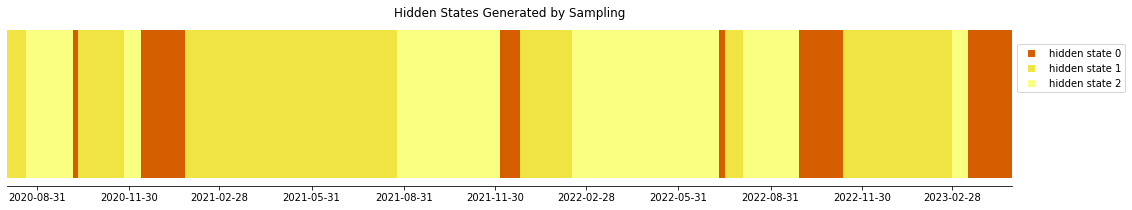

In [4]:
def state_plot(hidden_states, title):    
    splits = [0]
    for i in range(len(hidden_states)-1):
        if hidden_states.iloc[i] != hidden_states.iloc[i+1]:
            splits.append(i)

    fig, ax = plt.subplots(figsize = (18,3))

    left = splits[0]
    for i in range(len(splits)):
        state = hidden_states.iloc[splits[i]]
        ax.barh(1,splits[i], left = left, color = orange_colors[state])
        left = splits[i]

    ax.set_yticks([])
    ax.set_xlim(0,len(hidden_states))

    month_index = pd.date_range("2020-08-01",hidden_states.index[-1], freq = "3M")
    x_ticks = [list(hidden_states.index).index(m) for m in month_index]
    labels = [str(m).split(" ")[0] for m in month_index]
    ax.set_xticks(x_ticks)
    ax.set_xticklabels(labels)

    for i in range(len(hidden_states.unique())):
        ax.scatter([],[], marker = "s", color = orange_colors[i], label = "hidden state {}".format(i))

    ax.spines['top'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['right'].set_visible(False)

    plt.legend(bbox_to_anchor = (1,.9), loc = "upper left")
    plt.title(title)
    plt.show()
    
state_plot(hidden_states, title = "Hidden States Generated by Sampling")

We've set up a series of hidden states, and now we can use this to generate synthetic data that is distributed according to `hidden_states` and the generative model parameters.  We'll also look at some visualizations of the generated data.

In [5]:
hmm_data = generative_model.generate_observations(hidden_states)
hmm_data.head()

,categorical_feature_0,gaussian_feature_0,gaussian_feature_1
2020-08-01,1,-3.478830,-1.063201
2020-08-02,1,-1.465268,0.806984
2020-08-03,1,-5.594069,-2.479159
2020-08-04,1,-5.763692,-3.917942
2020-08-05,1,-5.524742,-2.375031


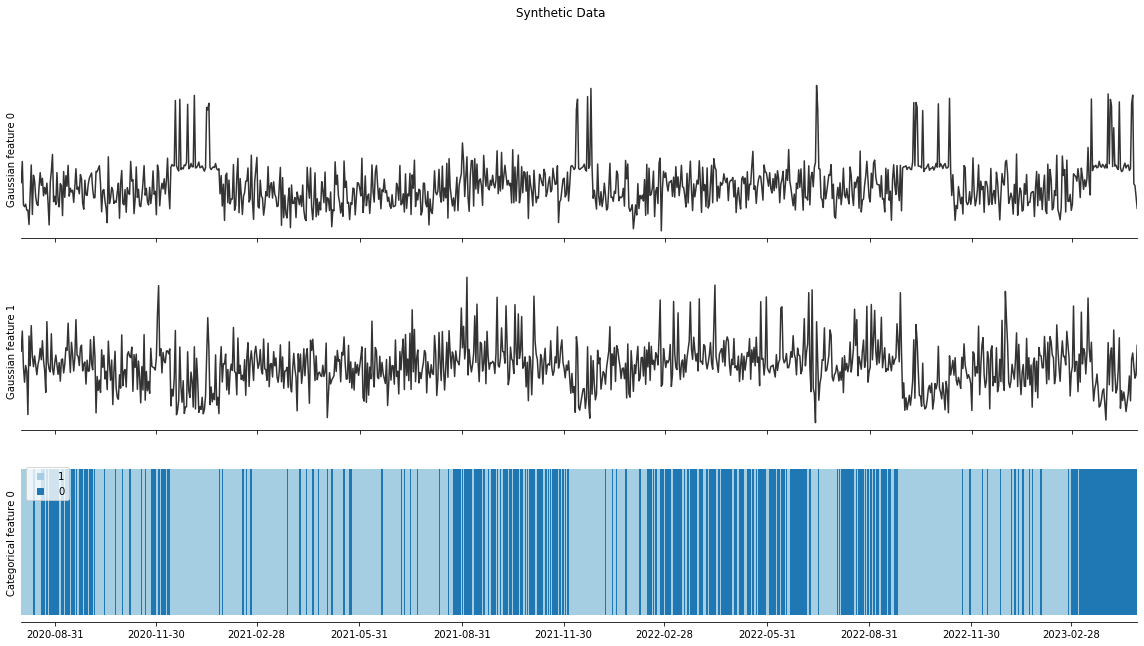

In [6]:
fig, ax = plt.subplots(nrows = 3, ncols = 1, figsize = (20,10), sharex = False)

# Get tick values and labels.
cat = hmm_data["categorical_feature_0"]
month_index = pd.date_range("2020-08-01",cat.index[-1], freq = "3M")
x_ticks = [list(cat.index).index(m) for m in month_index]
labels = [str(m).split(" ")[0] for m in month_index]

# Make Gaussian plot.
gauss = ["gaussian_feature_0","gaussian_feature_1"]
for i in range(len(gauss)):
    ax[i].plot(hmm_data[gauss[i]], color = "black", alpha = 0.8)
    ax[i].set_xlim(hmm_data.index[0], hmm_data.index[-1])


    ax[i].set_xticks(hmm_data.index[x_ticks])
    ax[i].set_xticklabels([])
    ax[i].set_yticks([])
    ax[i].set_yticklabels([])

    ax[i].spines['top'].set_visible(False)
    ax[i].spines['left'].set_visible(False)
    ax[i].spines['right'].set_visible(False)
    ax[i].set_ylabel("Gaussian feature {}".format(i))

# Make Categorical plot.
splits = [0]
for i in range(len(cat)-1):
    if cat.iloc[i] != cat.iloc[i+1]:
        splits.append(i)

left = splits[0]
for i in range(len(splits)):
    state = list(cat.unique()).index(cat.iloc[splits[i]])
    ax[2].barh(1,splits[i], left = left, color = blue_colors[state])
    left = splits[i]

ax[2].set_yticks([])
ax[2].set_xlim(0,cat.shape[0])
ax[2].set_xticks([])
ax[2].set_ylabel("Categorical feature 0")

ax[2].set_xticks(x_ticks)
ax[2].set_xticklabels(labels)

ax[2].spines['top'].set_visible(False)
ax[2].spines['left'].set_visible(False)
ax[2].spines['right'].set_visible(False)
    
for i in range(len(cat.unique())):
    ax[2].scatter([],[], marker = "s", color = blue_colors[i], label = "{}".format(cat.unique()[i]))
        
ax[2].legend()

fig.suptitle('Synthetic Data') 
plt.show()

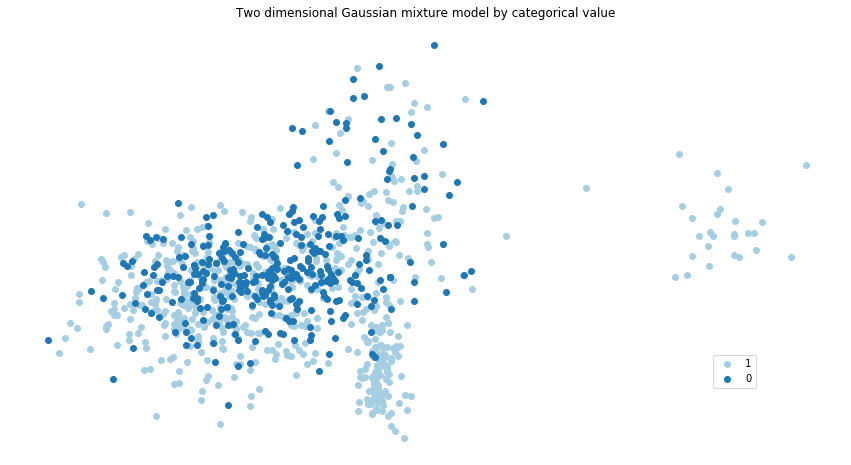

In [7]:
def colored_scatter(data,labels, label_prefix, title):
    fig, ax = plt.subplots(figsize = (15,8))
    markers = {0:"s",1:"^",2:"o"}

    for i in range(len(labels.unique())):
        c = blue_colors[i]
        m = markers[i]
        df = data[labels == labels.unique()[i]]
        ax.scatter(df["gaussian_feature_0"],df["gaussian_feature_1"], c=c, label = "{}".format(labels.unique()[i]))

    ax.set_xticks([])
    ax.set_yticks([])

    ax.spines['top'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
        
    plt.title(title)
    plt.legend(bbox_to_anchor = (.9,.15), loc = "lower right")
    plt.show()
    
colored_scatter(data = hmm_data, 
                labels = hmm_data["categorical_feature_0"], 
                label_prefix = "categorical feature", 
                title = "Two dimensional Gaussian mixture model by categorical value")

## Classical HMM Training and Inference

### Training

Define a training spec seeded with values from the generative model (this isn't an exact copy of the hmm underlying the gerneative model, but it's meant to be "close enough").  To keep consistency with the HMM and factored HMM results, I'm going to ignore the categorical features for now.

In [8]:
em_train_ll = []

actual_spec = generative_model.generative_model_to_discrete_hmm_training_spec()
model_config = hmm.DiscreteHMMConfiguration.from_spec(actual_spec)
actual_model = model_config.to_model()

hmm_inf = actual_model.load_inference_interface()
log_prob = hmm_inf.predict_hidden_state_log_probability(hmm_data)
ll = -1 * logsumexp(hmm_inf._compute_forward_probabilities(log_prob)[-1])

print("Complete data negative log likelihood: {}".format(ll))

Complete data negative log likelihood: 3802.1364644464506


In [9]:
# Generate new data for training.

hmm_data_train = generative_model.generate_observations(hidden_states)

training_spec = hmm_gen.data_to_discrete_hmm_training_spec(hidden_states=hidden_states, 
                                       n_hidden_states=generative_model.n_hidden_states, 
                                       data=hmm_data_train, 
                                       categorical_features =list(generative_model.categorical_values.columns),
                                       gaussian_features=list(generative_model.gaussian_values.columns),
                                       n_gmm_components=2)

model_config = hmm.DiscreteHMMConfiguration.from_spec(training_spec)

untrained_model = model_config.to_model()

In [10]:
# Load learning algorithm.
alg = untrained_model.load_learning_interface()

In [11]:
# Train model.
n_em_iterations = 10
model = alg.run(untrained_model, hmm_data_train, n_em_iterations)

em_train_likelihood = []
for m in alg.model_results:

    hmm_inf = m.load_inference_interface()
    log_prob = hmm_inf.predict_hidden_state_log_probability(hmm_data_train)
    em_train_likelihood.append(
            -1 * logsumexp(hmm_inf._compute_forward_probabilities(log_prob)[-1]))

em_train_ll.append(em_train_likelihood)

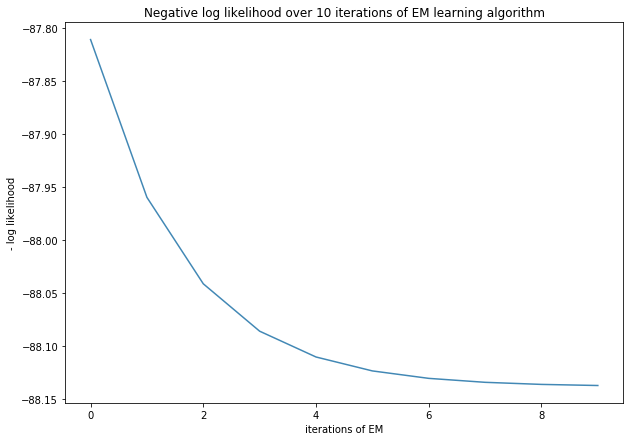

In [12]:
plt.figure(figsize = (10,7))

for train_ll in em_train_ll:
    plt.plot(np.array(train_ll) - ll, color = "#4288B5")

plt.title("Negative log likelihood over {} iterations of EM learning algorithm".format(n_em_iterations))

plt.ylabel("- log likelihood")
plt.xlabel("iterations of EM")
plt.show()

## Inference 

We will predict the most likely sequence of hidden states using the Viterbi algorithm.  Then we can compare this to the actual sequence of hidden states.


Viterbi proportion of correctly assigned hidden states: 0.981


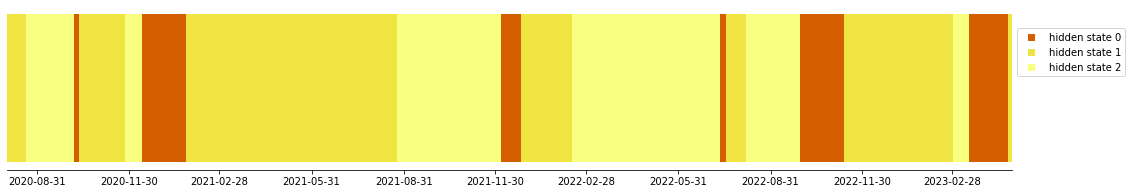

In [13]:
inf = model.load_inference_interface()
viterbi_predict = inf.predict_hidden_states_viterbi(hmm_data)
prop_correct = hidden_states[viterbi_predict == hidden_states].shape[0] / hidden_states.shape[0]
print("Viterbi proportion of correctly assigned hidden states: {}".format(prop_correct))

state_plot(viterbi_predict, title = None)


# Imputation

We can use our trained hmm to impute missing values. In reality it is very unlikely that we would need to impute missing values, but this is also a good way to see how well the model "understands" the data.

In [14]:
# Create artificial incomplete data.
incomplete_data = hmm_data.copy()
incomplete_data.loc[np.random.choice(hmm_data.index), np.random.choice(hmm_data.columns, 2)] = np.nan

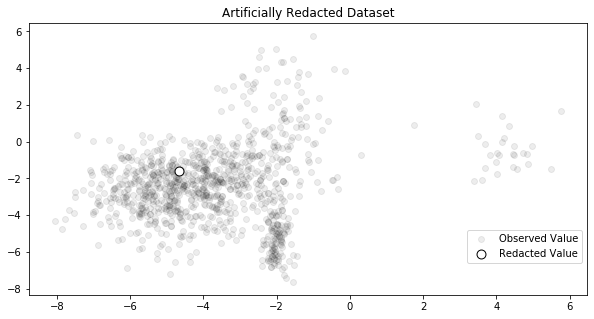

In [15]:
def imputed_scatter_all(data,
                        incomplete_data = None, 
                        imputed_data_hmm_avg = None, 
                        imputed_data_hmm_arg = None, 
                        imputed_data_hmm_max = None, 
                        title = None):
    fig, ax = plt.subplots(figsize = (10,5))
    markers = {0:"s",1:"^",2:"o"}

    df = data[~data.isna().any(axis = 1)]

    ax.scatter(df["gaussian_feature_0"],df["gaussian_feature_1"], c="black", alpha = 0.07, label = "Observed Value")
    
    if incomplete_data is not None:
        df = data[incomplete_data.isna().any(axis = 1)]

        ax.scatter(df["gaussian_feature_0"],df["gaussian_feature_1"], 
                   color=COLOR_MAP["black"], 
                   alpha = 1, 
                   marker ="o",
                   facecolors = "white",
                   s = 80,
                   label = "Redacted Value")
        
    if imputed_data_hmm_arg is not None:
        ax.scatter(imputed_data_hmm_arg.loc[df.index,"gaussian_feature_0"],
                   imputed_data_hmm_arg.loc[df.index,"gaussian_feature_1"], 
                              color = COLOR_MAP["light_orange"], 
                              marker = "D", 
                              s = 80,
                              label = "HMM Argmax Method Imputed Value")
        
    if imputed_data_hmm_max is not None:
        ax.scatter(imputed_data_hmm_max.loc[df.index,"gaussian_feature_0"],
                   imputed_data_hmm_max.loc[df.index,"gaussian_feature_1"], 
                              color = COLOR_MAP["green"], 
                              marker = "D", 
                   s = 80,
                            label = "HMM Maximal Method Imputed Value")
        
    if imputed_data_hmm_avg is not None:
        ax.scatter(imputed_data_hmm_avg.loc[df.index,"gaussian_feature_0"],
                   imputed_data_hmm_avg.loc[df.index,"gaussian_feature_1"], 
                              color = COLOR_MAP["light_blue"], 
                              marker = "D", 
                   s = 80,
                              label = "HMM Average Method Imputed Value")


    plt.title(title)
    plt.legend(bbox_to_anchor = (1,.1), loc = "lower right")
    plt.show()
    
imputed_scatter_all(hmm_data,
                        incomplete_data = incomplete_data,  
                        title = "Artificially Redacted Dataset")

In [16]:
# Load imputation tool.
imp = hmm.HMMImputationTool(model = model)

imputed_data_hmm_avg = imp.impute_missing_data(
        incomplete_data, method='hmm_average')

imputed_data_hmm_arg = imp.impute_missing_data(
        incomplete_data, method='hmm_argmax')

imputed_data_hmm_max = imp.impute_missing_data(
        incomplete_data, method='hmm_maximal')

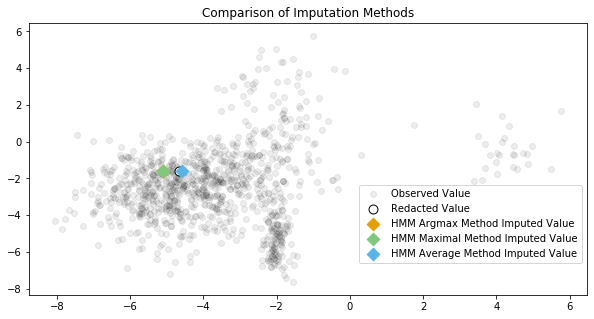

In [17]:
imputed_scatter_all(hmm_data,
                        incomplete_data, 
                        imputed_data_hmm_avg = imputed_data_hmm_avg, 
                        imputed_data_hmm_arg = imputed_data_hmm_arg, 
                        imputed_data_hmm_max = imputed_data_hmm_max, 
                        title = "Comparison of Imputation Methods")

# Forecasting

We also have tools to forecast values.

In [18]:
# Load forecasting tool.
forc = hmm.HMMForecastingTool(model = model, data = hmm_data.iloc[:-10])

In [19]:
horizon_timesteps = [1,5]
forecast = forc.forecast_observation_at_horizons(horizon_timesteps = horizon_timesteps)

forecast

,categorical_feature_0,gaussian_feature_0,gaussian_feature_1
2023-04-18,1,-0.804991,-3.923082
2023-04-22,1,-4.561536,-2.456930


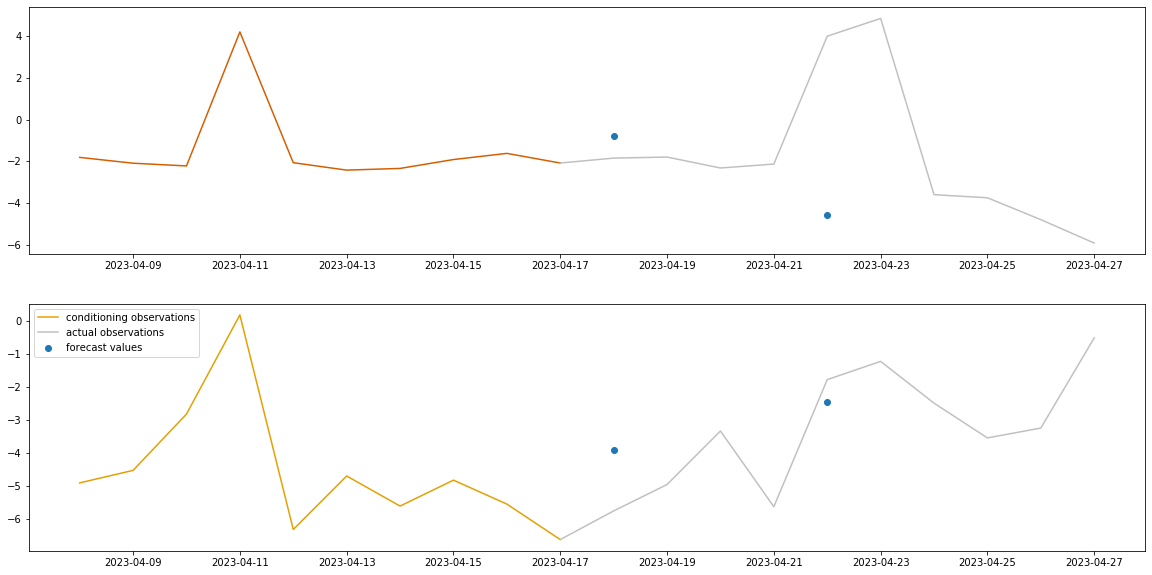

In [20]:
fig, ax = plt.subplots(nrows = 2, ncols = 1, figsize = (20,10), sharex = False)

data = hmm_data.iloc[-20:-10,:]
ax[0].plot(data.loc[:,"gaussian_feature_0"], color = COLOR_MAP["dark_orange"], label = "conditioning observations")
ax[0].plot(hmm_data.loc[hmm_data.index[-11:],"gaussian_feature_0"], color = COLOR_MAP["silver"], label = "actual observations")
ax[0].scatter(forecast.index, forecast.loc[:,"gaussian_feature_0"], label = "forecast values")
ax[1].plot(data.loc[:,"gaussian_feature_1"], color = COLOR_MAP["light_orange"], label = "conditioning observations")
ax[1].scatter(forecast.index, forecast.loc[:,"gaussian_feature_1"], label = "forecast values")
ax[1].plot(hmm_data.loc[hmm_data.index[-11:],"gaussian_feature_1"], color = COLOR_MAP["silver"], label = "actual observations")

plt.legend()
plt.show()

# HMM Validation Tools

Some preliminary methods are in place for validating forecasting and imputation in cases where the ground truth is known.

In [21]:
# Load validation tool.
val = hmm.HMMValidationTool(model = model, true_data = hmm_data)

## Validate Imputation

* `'relative_accuracy_of_imputed_finite_data'` should be be at least as good as random guessing, so it should be greater than 1.
* `'average_relative_log_likelihood_of_imputed_gaussian_data'` returns log p(actual value)-log p(imputed value) for conditonal distribution. With imputation method 'argmax' the imputed value should be at least as likely as the
    actual value, so this should always be negative.
* `'average_z_score_of_imputed_gaussian_data'` returns the average z score.
    If this is larger than 3.3 then my imputed values, are on average, worse than the 99.9% confidence
    interval and something has gone wrong.

In [22]:
val.validate_imputation(incomplete_data = incomplete_data,
                       data_to_verify = imputed_data_hmm_avg)

{'accuracy_of_imputed_finite_data': 1.0,
 'relative_accuracy_of_imputed_finite_data': 1.519756838905775,
 'best_possible_accuracy_of_finite_imputation': 1.519756838905775,
 'average_relative_log_likelihood_of_imputed_gaussian_data': 0.03651131154786302,
 'average_z_score_of_imputed_gaussian_data': 0.191997719656065}

In [23]:
val.validate_imputation(incomplete_data = incomplete_data,
                       data_to_verify = imputed_data_hmm_arg)

{'accuracy_of_imputed_finite_data': 1.0,
 'relative_accuracy_of_imputed_finite_data': 1.519756838905775,
 'best_possible_accuracy_of_finite_imputation': 1.519756838905775,
 'average_relative_log_likelihood_of_imputed_gaussian_data': -0.059959671372052936,
 'average_z_score_of_imputed_gaussian_data': 0.191997719656065}

In [24]:
val.validate_imputation(incomplete_data = incomplete_data,
                       data_to_verify = imputed_data_hmm_max)

{'accuracy_of_imputed_finite_data': 1.0,
 'relative_accuracy_of_imputed_finite_data': 1.519756838905775,
 'best_possible_accuracy_of_finite_imputation': 1.519756838905775,
 'average_relative_log_likelihood_of_imputed_gaussian_data': -0.059959671372052936,
 'average_z_score_of_imputed_gaussian_data': 0.191997719656065}

## Validate Forecast

In [25]:
val.validate_forecast(conditioning_data = hmm_data.iloc[:-10,:],
                       forecast = forecast)

DatetimeIndex(['2023-04-18', '2023-04-22'], dtype='datetime64[ns]', freq=None)


{'accuracy_of_forecast_finite_data': 1.0,
 'relative_accuracy_of_forecast_finite_data': 1.519756838905775,
 'best_possible_accuracy_of_finite_forecast': 1.5261538461538462,
 'average_relative_log_likelihood_of_forecast_gaussian_data': 0.17456405451069967,
 'average_z_score_of_forecast_gaussian_data': 3.9442781128990103}